# 🏥 Profitability Clustering for Healthcare Units

This notebook performs a complete analysis to **classify healthcare units** based on their **profitability**, using K-Means clustering.  
We follow the business logic:

📌 **Profitability = Revenue - Expenses**  
- Revenue = `total_cost` (paid by patient)  
- Expenses = `eq_price` + `Approximate_Annual_Salary` (equipment + salaries)

We visualize clusters, assign labels (High / Moderate / Low), and explain the meaning of each cluster.


In [1]:
import pandas as pd

# Load the data
fact_df = pd.read_csv("fact_rentablité.csv")
careunit_df = pd.read_csv("CareUnit_dim.csv")

# Merge to get CU_name
merged_df = fact_df.merge(careunit_df, left_on="CareUnit_fk", right_on="careunit_pk")
merged_df.head()

,Patient_fk,Patient_Flux_fk,Reclamation_fk,CareGivers_fk,CareUnit_fk,Diseases_fk,Equipement_fk,Admission_CU_Date_fk,Admission_Date_fk,Discharge_Date_fk,...,medication_cost,lab_test_cost,total_cost,eq_price,Monthly_Salary,Weekly_Salary,Approximate_Annual_Salary,careunit_pk,code_CU,CU_name
0,1,3,rec1,7.0,1,1,1,133254,133245,133254,...,21600,196300,236400,5284.36,5167,1192,62000,1,10006,MICU
1,2,5,rec2,12.0,2,2,2,119309,119295,119309,...,0,70000,86000,647.06,10000,2308,120000,2,10011,MICU
2,3,7,rec3,14.0,3,3,3,118984,118981,118984,...,3600,14800,21900,2803.94,6000,1385,72000,3,10013,MICU
3,4,13,rec4,18.0,4,4,4,127624,127616,127624,...,42000,47700,100700,821.89,10000,2308,120000,4,10017,CCU
4,5,15,rec5,1339.0,5,5,5,132719,132717,132718,...,0,28700,34700,1550.00,7917,1827,95000,5,10019,MICU


➡️ We merged care unit names into the fact table for analysis.

In [2]:
# Compute patient-level profitability
merged_df["profitability"] = merged_df["total_cost"] - (
    merged_df["eq_price"] + merged_df["Approximate_Annual_Salary"]
)

📌 Profitability per patient is computed as total revenue minus expenses.

In [3]:
# Group by care unit and compute mean profitability
grouped_df = merged_df.groupby("CU_name").agg({
    "profitability": "mean"
}).reset_index()

# Preview sorted profitability
grouped_df.sort_values("profitability", ascending=False)

,CU_name,profitability
2,MICU,196477.236471
3,SICU,130369.464444
0,CCU,43081.448571
4,TSICU,19227.340000
1,CSRU,6638.420000


✅ We now have the **average profitability per care unit**, ready for clustering.

K-Means Clustering

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Prepare and scale data
X = grouped_df[["profitability"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
grouped_df["cluster"] = kmeans.fit_predict(X_scaled)

# Evaluate
silhouette = silhouette_score(X_scaled, grouped_df["cluster"])
dbi = davies_bouldin_score(X_scaled, grouped_df["cluster"])
print(f"Silhouette Score: {silhouette:.3f}")
print(f"Davies-Bouldin Index: {dbi:.3f}")

Silhouette Score: 0.388
Davies-Bouldin Index: 0.270


📊 The clustering performance is evaluated using:

- **Silhouette Score** (closer to 1 = better separation)
- **Davies-Bouldin Index** (closer to 0 = better compactness)


In [5]:
# Determine real meaning of each cluster
cluster_avg = grouped_df.groupby("cluster")["profitability"].mean().sort_values()

profitability_labels = {
    cluster_avg.index[0]: "Low Profitability",
    cluster_avg.index[1]: "Moderate Profitability",
    cluster_avg.index[2]: "High Profitability"
}

# Assign labels
grouped_df["profitability_label"] = grouped_df["cluster"].map(profitability_labels)
grouped_df.sort_values("profitability", ascending=False)

,CU_name,profitability,cluster,profitability_label
2,MICU,196477.236471,1,High Profitability
3,SICU,130369.464444,1,High Profitability
0,CCU,43081.448571,2,Moderate Profitability
4,TSICU,19227.340000,0,Low Profitability
1,CSRU,6638.420000,0,Low Profitability


🎯 Each care unit is now labeled based on **actual profitability**, not cluster number.

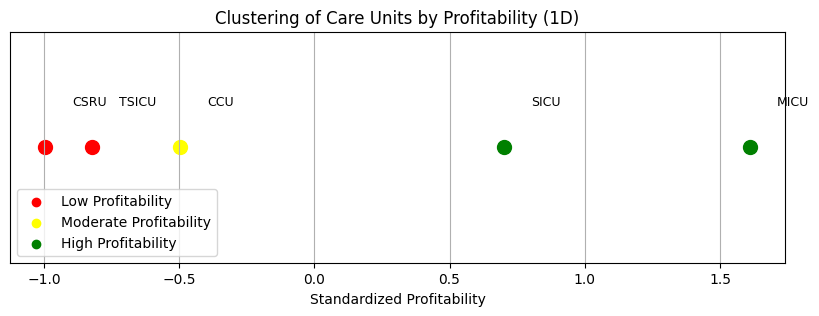

In [6]:
import matplotlib.pyplot as plt

# Business color palette
label_colors = {
    "Low Profitability": "red",
    "Moderate Profitability": "yellow",
    "High Profitability": "green"
}

# Plot
plt.figure(figsize=(10, 3))
for i in range(len(grouped_df)):
    label = grouped_df["profitability_label"][i]
    color = label_colors[label]
    x = X_scaled[i][0]
    plt.scatter(x, 0, color=color, s=100)
    plt.text(x + 0.1, 0.02, grouped_df["CU_name"][i], fontsize=9)

plt.title("Clustering of Care Units by Profitability (1D)")
plt.xlabel("Standardized Profitability")
plt.yticks([])
plt.grid(True)

# Legend
for label, color in label_colors.items():
    plt.scatter([], [], color=color, label=label)
plt.legend()
plt.show()

🟢 **Green**: High profitability care units  
🟡 **Yellow**: Moderate profit  
🔴 **Red**: Units with lowest profitability  

✅ This color-coded plot makes it easy to communicate cluster meaning to stakeholders.


In [7]:
# Export to Power BI
grouped_df.to_csv("clustered_care_units_by_profitability.csv", index=False)
print("✅ Exported to clustered_care_units_by_profitability.csv")

✅ Exported to clustered_care_units_by_profitability.csv


Agglomerative Clustering

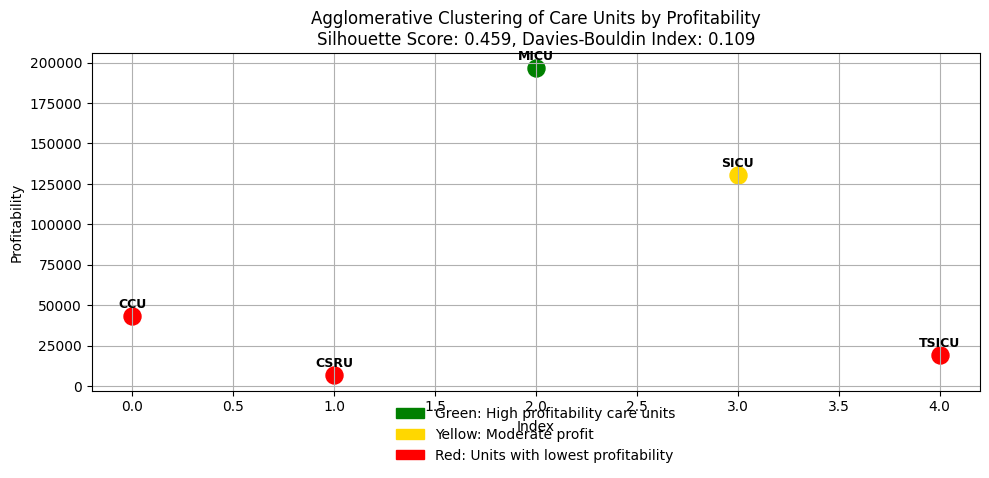

In [16]:
import matplotlib.patches as mpatches

# Step 1: Define a mapping from cluster to color
# ⚠️ Adjust this mapping based on your cluster interpretation
color_map = {
    0: "red",      # Lowest profitability
    1: "gold",     # Moderate
    2: "green"     # High
}

# Step 2: Map colors to a new column
grouped_df["color"] = grouped_df["agglo_cluster"].map(color_map)

# Step 3: Plot manually with custom colors
plt.figure(figsize=(10, 5))

# Plot each point with its corresponding color
for i in range(len(grouped_df)):
    plt.scatter(
        x=grouped_df.index[i],
        y=grouped_df["profitability"].iloc[i],
        color=grouped_df["color"].iloc[i],
        s=150
    )
    plt.text(
        x=grouped_df.index[i],
        y=grouped_df["profitability"].iloc[i] + 5000,
        s=grouped_df["CU_name"].iloc[i],
        ha='center',
        fontsize=9,
        weight='bold'
    )

# Custom legend patches
legend_patches = [
    mpatches.Patch(color='green', label='Green: High profitability care units'),
    mpatches.Patch(color='gold', label='Yellow: Moderate profit'),
    mpatches.Patch(color='red', label='Red: Units with lowest profitability')
]


plt.legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=1, frameon=False)

# Title & Labels
plt.title(f"Agglomerative Clustering of Care Units by Profitability\nSilhouette Score: {sil_agg:.3f}, Davies-Bouldin Index: {dbi_agg:.3f}")
plt.xlabel("Index")
plt.ylabel("Profitability")
plt.grid(True)
plt.tight_layout()
plt.show()


Silhouette Score (higher = better):
Measures how well-separated and cohesive clusters are.
→ Agglomerative has clearer separation.

Davies-Bouldin Index (lower = better):
Measures inter-cluster similarity (you want low overlap).
→ Agglomerative has much tighter clusters.